**Описание:** Файл для теста моделей, их оптимизации и поиска оптимальных признаков

In [196]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# processing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance

# saving model
import pickle

In [224]:
import session_info
session_info.show()

In [197]:
RANDOM_STATE = 32

In [3]:
DATASET_PATH = "./data/preprocessed_data.csv"

## Загрузка данных

In [4]:
# загрузка данных
df = pd.read_csv(DATASET_PATH)

In [5]:
df.sample(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
85677,0,0.093062,59.0,1,1756.000000,6250.0,12,0,0,0.0,A,d
85466,0,0.444544,47.0,0,0.366996,8307.0,7,0,0,2.0,A,c
75205,0,0.032781,48.0,0,0.247479,12000.0,13,0,0,3.0,B,c
58949,0,0.000000,51.0,0,0.429592,3500.0,14,0,0,3.0,A,d
2642,1,0.922269,42.0,1,0.174403,3726.0,3,0,0,4.0,A,c


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131679 entries, 0 to 131678
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      131679 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  131679 non-null  float64
 2   age                                   131679 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  131679 non-null  int64  
 4   DebtRatio                             131679 non-null  float64
 5   MonthlyIncome                         131679 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       131679 non-null  int64  
 7   NumberOfTimes90DaysLate               131679 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  131679 non-null  int64  
 9   NumberOfDependents                    131679 non-null  float64
 10  RealEstateLoansOrLines                131679 non-null  object 
 11  

In [7]:
target = ['SeriousDlqin2yrs']
cat_features = ['RealEstateLoansOrLines', 'GroupAge']
num_features = list(set(df.columns.to_list())- set(target) -set(cat_features))

df = df.astype({target[0]:int})

## Пайплайн модели

1) Отмасштабировать признаки;
2) Закодировать категориальные(?);
3) Сбалансировать классы(?);
4) Обучить модель;
5) Выбрать порог.

In [8]:
df[target].value_counts()

SeriousDlqin2yrs
0                   123780
1                     7899
dtype: int64

In [198]:
X = df[num_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = RANDOM_STATE,
                                                    shuffle=True
                                                   )

### Наивная модель

In [77]:
%%time
lreg = LogisticRegression(max_iter=500)
lreg.fit(X_train, y_train.to_numpy()[:,0])

print("ROC-AUC score(train): ", roc_auc_score(y_train, lreg.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, lreg.predict_proba(X_test)[:,1]))

pred = lreg.predict(X_test)
print(classification_report(y_test, pred))

ROC-AUC score(train):  0.8406074827495302
ROC-AUC score(test):  0.8456233188762838
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     37139
           1       0.57      0.15      0.23      2365

    accuracy                           0.94     39504
   macro avg       0.76      0.57      0.60     39504
weighted avg       0.93      0.94      0.93     39504

Wall time: 3.13 s


In [78]:
df_1 = df.loc[df[target[0]]==1]
df_1 = df_1.loc[df_1.index.repeat(15)]

df_train = pd.concat([df.loc[df[target[0]]==0], df_1]).sample(frac=1)

In [199]:
%%time
X = df_train[num_features]
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = RANDOM_STATE,
                                                    shuffle=True)


lreg = LogisticRegression(max_iter=100)
lreg.fit(X_train, y_train.to_numpy()[:,0])

print("ROC-AUC score(train): ", roc_auc_score(y_train, lreg.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, lreg.predict_proba(X_test)[:,1]))

pred = lreg.predict(X_test)
print(classification_report(y_test, pred))

ROC-AUC score(train):  0.837784910779425
ROC-AUC score(test):  0.8362113631159429
              precision    recall  f1-score   support

           0       0.72      0.84      0.78     36990
           1       0.80      0.66      0.72     35690

    accuracy                           0.75     72680
   macro avg       0.76      0.75      0.75     72680
weighted avg       0.76      0.75      0.75     72680

Wall time: 1.75 s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Видно, как upsampling значительно увеличивает точность предсказания для 1го класса

### XgboostClassifier + scaling/normalization

In [200]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d


In [201]:
columns_need_normalize = ["DebtRatio", "MonthlyIncome"]

In [202]:
# Setup the pipeline steps: steps
# transformer = ColumnTransformer(
#     transformers=[('scaler', RobustScaler(), num_features),
#                  ('norm', Normalizer(), num_features)
#                  ]
# )

# steps_1 = [('t', transformer),
#          ('lreg_model', LogisticRegression())]

# steps_2 = [('t', transformer),
#          ('xgb_model', XGBClassifier(n_jobs=-1))]

steps_1 = [('scaler', RobustScaler()),
           ('norm', Normalizer()),
         ('lreg_model', LogisticRegression())]

steps_2 = [('scaler', RobustScaler()),
           ('norm', Normalizer()),
         ('xgb_model', XGBClassifier(n_jobs=-1))]

# Create the pipeline: lreg_pipeline
lreg_pipeline = Pipeline(steps_1)
# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps_2)

In [203]:
# training
xgb_pipeline.fit(X_train, y_train.to_numpy())

print("ROC-AUC score(train): ", roc_auc_score(y_train, xgb_pipeline.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:,1]))

pred = xgb_pipeline.predict(X_test)
print(classification_report(y_test, pred))

ROC-AUC score(train):  0.9225287878185995
ROC-AUC score(test):  0.9119070135575403
              precision    recall  f1-score   support

           0       0.85      0.82      0.83     36990
           1       0.82      0.85      0.84     35690

    accuracy                           0.84     72680
   macro avg       0.84      0.84      0.84     72680
weighted avg       0.84      0.84      0.84     72680



In [204]:
lreg_pipeline.fit(X_train, y_train.to_numpy())

print("ROC-AUC score(train): ", roc_auc_score(y_train, lreg_pipeline.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, lreg_pipeline.predict_proba(X_test)[:,1]))

pred = lreg_pipeline.predict(X_test)
print(classification_report(y_test, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ROC-AUC score(train):  0.8180077086433251
ROC-AUC score(test):  0.817681788471527
              precision    recall  f1-score   support

           0       0.70      0.82      0.75     36990
           1       0.77      0.63      0.70     35690

    accuracy                           0.73     72680
   macro avg       0.74      0.73      0.73     72680
weighted avg       0.74      0.73      0.73     72680



## Оптимизация модели

### ROC кривая

In [157]:
def plot_roc_curve(X_test, y_test, model, label):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=label)

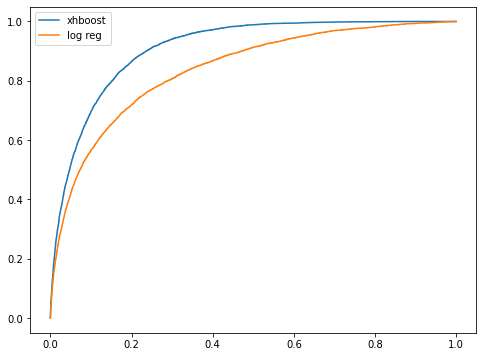

In [158]:
plt.figure(figsize=(8,6))
plot_roc_curve(X_test, y_test, xgb_pipeline, "xhboost")
plot_roc_curve(X_test, y_test, lreg, "log reg")
plt.legend()

#### GridSearchCV

In [21]:
parameters = {"xgb_model__learning_rate":[0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "xgb_model__n_estimators":[200,250,300],
              "xgb_model__max_depth":[3,4,5,6,8]
             }

grid_search = GridSearchCV(xgb_pipeline, 
                           parameters, 
                           scoring='roc_auc',
                           verbose=1)

In [22]:
# %%time
# grid_search.fit(X_train, y_train)

In [23]:
# grid_search.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

Метод надёжный, но очень долгий и неоптимальный

#### Bayesian Optimization

In [24]:
!pip install hyperopt -q

In [25]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [26]:
space={'xgb_model__max_depth': hp.quniform("max_depth", 3, 15, 1),
       'xgb_model__gamma': hp.uniform ('gamma', 1,9),
       # 'xgb_model__reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       # 'xgb_model__reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'xgb_model_colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'xgb_model_min_child_weight' : hp.quniform('min_child_weight', 1, 10, 2),
        'xgb_model_n_estimators': hp.quniform('n_estimators', 200, 400, 50),
        'xgb_model_seed': 0
    }

In [27]:
def objective_pipe(params):
    transformer = ColumnTransformer( 
        transformers=[('scaler', RobustScaler(), columns_need_normalize),
                      ('norm', Normalizer(), num_features)])

    steps_2 = [('t', transformer),
               ('xgb_model', XGBClassifier(n_jobs=-1))]

    # Create the pipeline: xgb_pipeline
    xgb_pipeline = Pipeline(steps_2)

    score = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK}

In [30]:
trials = Trials()

best_hyperparams = fmin(fn = objective_pipe,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|█████████████████████████████████████████████| 100/100 [36:18<00:00, 21.79s/trial, best loss: -0.9124312038095936]


In [159]:
# transform dictionary to pipeline parameters
best_hyperparams_pipe = {}
for key in best_hyperparams.keys():
    if key=='max_depth' or key=='min_child_weight' or key=='n_estimators':
        best_hyperparams_pipe['xgb_model__' + key] = int(best_hyperparams[key])
        continue
    best_hyperparams_pipe['xgb_model__' + key] = best_hyperparams[key]

In [160]:
print("The best hyperparameters: ")
print(best_hyperparams_pipe)

The best hyperparameters: 
{'xgb_model__colsample_bytree': 0.6387185459453528, 'xgb_model__gamma': 3.416839667082975, 'xgb_model__max_depth': 5, 'xgb_model__min_child_weight': 8, 'xgb_model__n_estimators': 250}


In [172]:
xgb_pipeline.set_params(**best_hyperparams_pipe)
xgb_pipeline.fit(X_train, y_train.to_numpy())

Pipeline(steps=[('scaler', RobustScaler()), ('norm', Normalizer()),
                ('xgb_model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6387185459453528,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=3.416839667082975, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=8,
                               missing=nan, monotone_constraints='()',
                               n_estimators=250, n_jo

In [173]:
print("ROC-AUC score(train): ", roc_auc_score(y_train, xgb_pipeline.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:,1]))

pred = xgb_pipeline.predict(X_test)
print(classification_report(y_test, pred))

ROC-AUC score(train):  0.9293372112914209
ROC-AUC score(test):  0.9194606031685637
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     36872
           1       0.83      0.86      0.85     35808

    accuracy                           0.85     72680
   macro avg       0.85      0.85      0.85     72680
weighted avg       0.85      0.85      0.85     72680



Wall time: 52.5 s


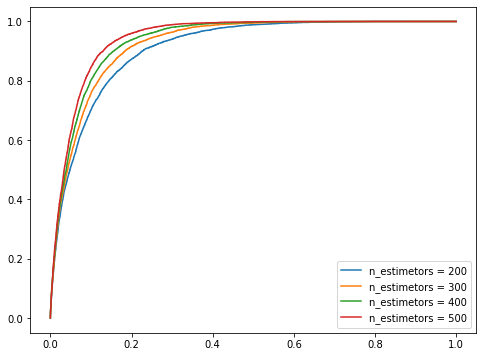

In [174]:
%%time
plt.figure(figsize=(8,6))
for n_est in [200,300,400,500]:
    best_hyperparams_pipe["xgb_model__n_estimators"] = n_est
    xgb_pipeline.set_params(**best_hyperparams_pipe)
    xgb_pipeline.fit(X_train, y_train.to_numpy())

    
    plot_roc_curve(X_test, y_test, xgb_pipeline, f"n_estimetors = {n_est}")
plt.legend()

<BarContainer object of 9 artists>

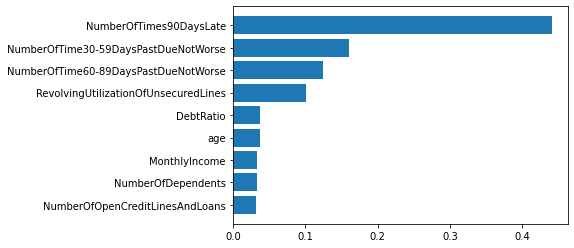

In [175]:
sorted_idx = xgb_pipeline[2].feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_pipeline[2].feature_importances_[sorted_idx])

In [205]:
# another pipeline (separate data columns)
columns_need_scalered = ["DebtRatio", "MonthlyIncome"]

transformer = ColumnTransformer(
    transformers=[('scaler', RobustScaler(), columns_need_scalered),
                 ('norm', Normalizer(), list(set(num_features)-set(columns_need_scalered)))
                 ]
)

steps = [('t', transformer),
         ('xgb_model', XGBClassifier(n_jobs=-1))]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

xgb_pipeline.set_params(**best_hyperparams_pipe)
xgb_pipeline.fit(X_train, y_train.to_numpy())

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['DebtRatio',
                                                   'MonthlyIncome']),
                                                 ('norm', Normalizer(),
                                                  ['RevolvingUtilizationOfUnsecuredLines',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'NumberOfDependents',
                                                   'NumberOfTime60-89DaysPastDueNotWorse',
                                                   'age',
                                                   'NumberOfTimes90DaysLate',
                                                   'NumberOfOpenCreditLinesAndLoans'])])),
                ('xgb_mode...
                               gamma=3.416839667082975, gpu_id=-1,
                          

In [206]:
print("ROC-AUC score(train): ", roc_auc_score(y_train, xgb_pipeline.predict_proba(X_train)[:,1]))
print("ROC-AUC score(test): ", roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:,1]))

pred = xgb_pipeline.predict(X_test)
print(classification_report(y_test, pred))

ROC-AUC score(train):  0.9509715753049177
ROC-AUC score(test):  0.9340351916729709
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     36990
           1       0.85      0.87      0.86     35690

    accuracy                           0.86     72680
   macro avg       0.86      0.86      0.86     72680
weighted avg       0.86      0.86      0.86     72680



### Сохранение модели

In [195]:
with open('./models/xgb_pipeline.pickle', 'wb') as f:
    pickle.dump(xgb_pipeline, f)

In [228]:
with open('./models/xgb_pipeline.pickle', 'rb') as f:
    model = pickle.load(f)

In [229]:
model

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['DebtRatio',
                                                   'MonthlyIncome']),
                                                 ('norm', Normalizer(),
                                                  ['RevolvingUtilizationOfUnsecuredLines',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'NumberOfDependents',
                                                   'NumberOfTime60-89DaysPastDueNotWorse',
                                                   'age',
                                                   'NumberOfTimes90DaysLate',
                                                   'NumberOfOpenCreditLinesAndLoans'])])),
                ('xgb_mode...
                               gamma=3.416839667082975, gpu_id=-1,
                          

In [234]:
list(resp.keys())

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfDependents',
 'DebtRatio',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'age',
 'NumberOfTimes90DaysLate',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

In [238]:
resp = {
        'RevolvingUtilizationOfUnsecuredLines': [1],
        'NumberOfTime30-59DaysPastDueNotWorse': [1], 
        'NumberOfDependents': [1],
        'DebtRatio': [1], 
        'NumberOfTime60-89DaysPastDueNotWorse': [1], 
        'age': [1],
        'NumberOfTimes90DaysLate': [1], 
        'MonthlyIncome': [1],
        'NumberOfOpenCreditLinesAndLoans': [1]
        }
data = pd.DataFrame.from_dict(resp)

In [240]:
model.predict(data)[0]

1